<a href="https://colab.research.google.com/github/aryan-achyut/Computer-Vision-Project/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


                           Stock Price          Regime
Date                                                  
2020-01-02 00:00:00+00:00    72.876099  Low Volatility
2020-01-03 00:00:00+00:00    72.167595  Low Volatility
2020-01-06 00:00:00+00:00    72.742653  Low Volatility
2020-01-07 00:00:00+00:00    72.400551  Low Volatility
2020-01-08 00:00:00+00:00    73.565208  Low Volatility


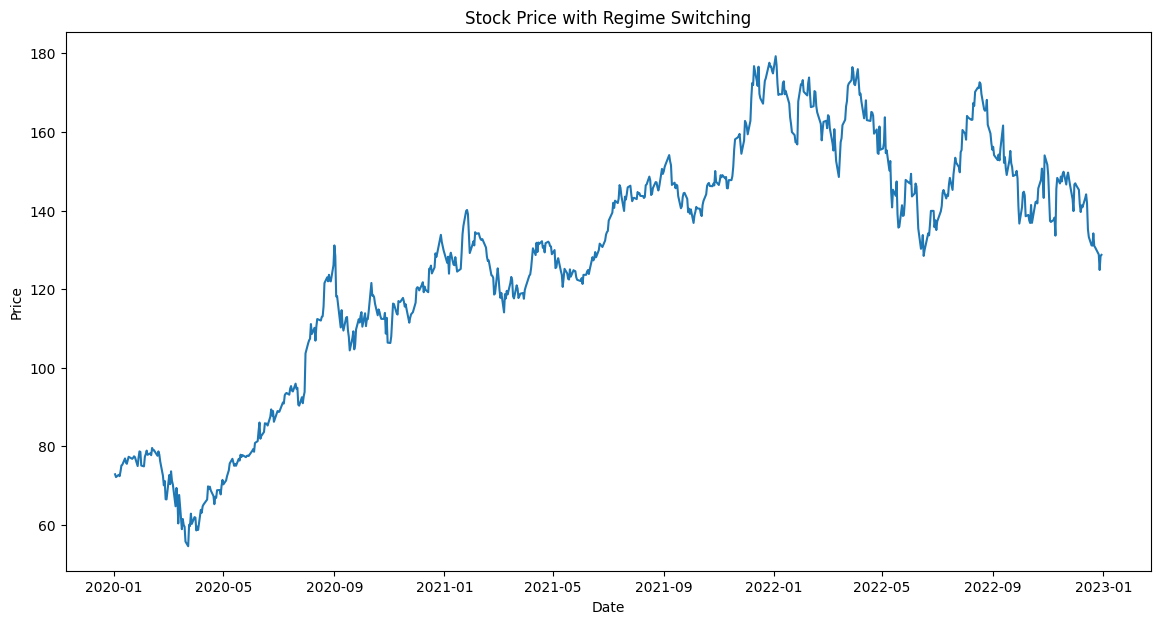

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical stock price data from Yahoo Finance
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

# Fetch risk-free rate (e.g., 10-year US Treasury yield)
def fetch_risk_free_rate():
    # You can fetch this from FRED (Federal Reserve Economic Data)
    # Use 'yahoo' for simplified access or web scraping
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate regime switching using a semi-Markov process
def simulate_regime_switching(num_days):
    regimes = ['Low Volatility', 'High Volatility']
    # Transition probabilities (for simplicity, using a 2-state Markov chain)
    transition_matrix = np.array([[0.95, 0.05], [0.10, 0.90]])  # Example transition matrix
    regime_sequence = []
    current_state = 0  # Start in state 0 (Low Volatility)

    for _ in range(num_days):
        regime_sequence.append(regimes[current_state])
        current_state = np.random.choice([0, 1], p=transition_matrix[current_state])

    return regime_sequence

# Simulate market data based on stock prices and regime
def simulate_market_data(stock_data, regime_sequence):
    market_data = pd.DataFrame(index=stock_data.index)
    market_data['Stock Price'] = stock_data
    market_data['Regime'] = regime_sequence
    return market_data

# Example Usage
if __name__ == "__main__":
    # Define parameters
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # List of stocks
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)
    risk_free_rate = fetch_risk_free_rate()

    # Simulate regime switching for the same period
    regime_sequence = simulate_regime_switching(len(stock_data))

    # Combine data into a market dataset
    market_data = simulate_market_data(stock_data['AAPL'], regime_sequence)  # Using Apple as an example

    # Display the market data
    print(market_data.head())

    # Plot stock price and regime over time
    plt.figure(figsize=(14, 7))
    plt.plot(market_data['Stock Price'], label='AAPL Stock Price')
    plt.title('Stock Price with Regime Switching')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


1. Imports and Helper Functions


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate regime switching using a semi-Markov process
def simulate_regime_switching(num_days):
    regimes = ['Low Volatility', 'High Volatility']
    transition_matrix = np.array([[0.95, 0.05], [0.10, 0.90]])
    regime_sequence = []
    current_state = 0  # Start in Low Volatility
    for _ in range(num_days):
        regime_sequence.append(regimes[current_state])
        current_state = np.random.choice([0, 1], p=transition_matrix[current_state])
    return regime_sequence

# Simulate jump diffusion with Poisson jumps
def simulate_jump_diffusion(stock_data, lambda_jumps, mu_jump, sigma_jump):
    n = len(stock_data)
    jump_component = np.random.poisson(lambda_jumps, n) * np.random.normal(mu_jump, sigma_jump, n)
    return jump_component

# Combine everything into market data
def simulate_market_data(stock_data, regime_sequence, lambda_jumps, mu_jump, sigma_jump):
    market_data = pd.DataFrame(index=stock_data.index)
    market_data['Stock Price'] = stock_data
    market_data['Regime'] = regime_sequence

    # Simulate jumps in stock prices
    jumps = simulate_jump_diffusion(stock_data, lambda_jumps, mu_jump, sigma_jump)
    market_data['Stock Price with Jumps'] = market_data['Stock Price'] + jumps
    return market_data


2. Portfolio Optimization Framework


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-3-b5c5bce4a0ee>:27: RuntimeWarning: divide by zero encountered in scalar divide
  u_opt[t] = (1 / theta) * (V[t] * (next_price - r_t) / (sigma_t ** 2))


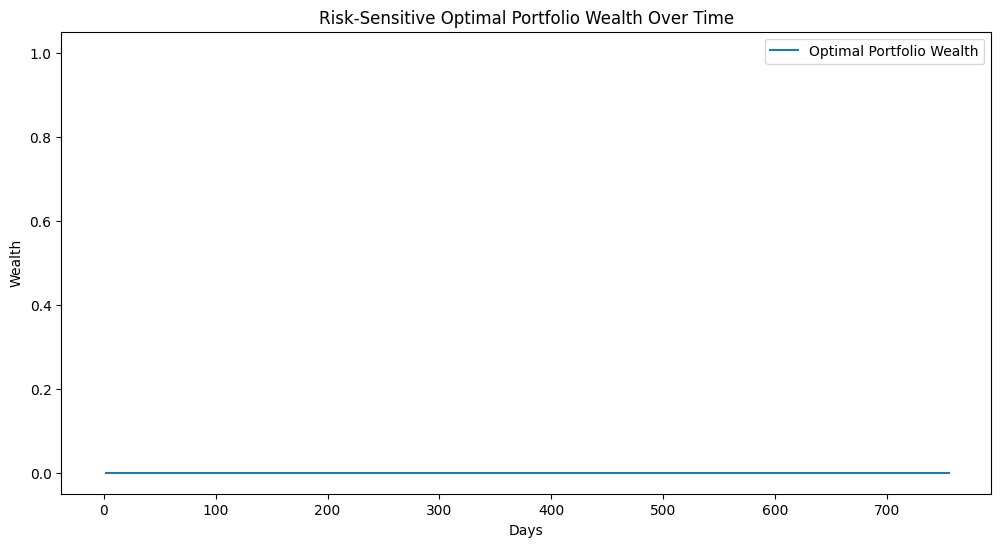

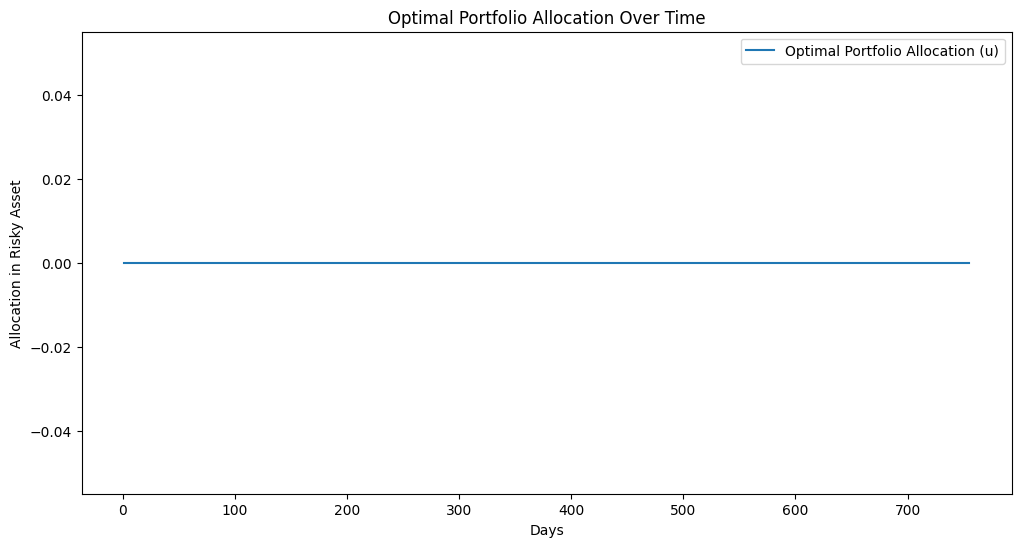

In [ ]:
# Define utility and HJB equation for risk-sensitive optimization
def utility_function(V, theta):
    return -(2 / theta) * np.log(V)

# Hamilton-Jacobi-Bellman (HJB) solution approximation using finite difference
def hjb_optimization(market_data, theta, T):
    # Initialize parameters for the HJB solution
    num_steps = len(market_data)
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    # Initial wealth
    V[0] = 1.0  # Assume $1 initial wealth
    dt = 1  # Time step in days

    # Risk-sensitive HJB equation solution (backward in time)
    for t in range(num_steps - 2, -1, -1):
        current_price = market_data['Stock Price with Jumps'].iloc[t]
        next_price = market_data['Stock Price with Jumps'].iloc[t + 1]
        r_t = 0.01  # Example risk-free rate, can be fetched

        # Estimate the optimal control u (proportion in risky asset)
        dV = (next_price - current_price) / current_price
        sigma_t = np.std(market_data['Stock Price with Jumps'][:t+1])

        # HJB optimal control based on the risk-sensitive objective
        u_opt[t] = (1 / theta) * (V[t] * (next_price - r_t) / (sigma_t ** 2))

        # Update the wealth based on optimal control
        V[t + 1] = V[t] * (1 + u_opt[t] * dV + r_t * dt)

    return V, u_opt

# Example usage:
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)
    risk_free_rate = fetch_risk_free_rate()

    # Simulate regime switching
    regime_sequence = simulate_regime_switching(len(stock_data))

    # Simulate jump diffusion for AAPL
    lambda_jumps = 0.1  # Average number of jumps per day
    mu_jump = 0.01  # Average jump size
    sigma_jump = 0.02  # Jump volatility
    market_data = simulate_market_data(stock_data['AAPL'], regime_sequence, lambda_jumps, mu_jump, sigma_jump)

    # Apply risk-sensitive HJB optimization
    theta = 0.5  # Risk-aversion parameter
    T = len(market_data)  # Time horizon
    V_opt, u_opt = hjb_optimization(market_data, theta, T)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(V_opt, label='Optimal Portfolio Wealth')
    plt.title('Risk-Sensitive Optimal Portfolio Wealth Over Time')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(u_opt, label='Optimal Portfolio Allocation (u)')
    plt.title('Optimal Portfolio Allocation Over Time')
    plt.xlabel('Days')
    plt.ylabel('Allocation in Risky Asset')
    plt.legend()
    plt.show()

1. Refining the Model: Heston Stochastic Volatility and Correlated Jumps


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 0)  # Ensure non-negative volatility
    return sigma

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    # Poisson process for jump times
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    # Multivariate normal for correlated jump sizes
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    # Apply jumps when jump occurs
    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    # Simulate stochastic volatility
    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)

    # Simulate correlated jumps
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    # Apply volatility and jumps to asset prices
    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.01  # Assume constant drift
            market_data[asset].iloc[t] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

2. Improved Numerical Solver: Implicit Finite Difference and Dynamic Programming


[*********************100%***********************]  5 of 5 completed
<ipython-input-4-0f7836fa9606>:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  market_data[asset].iloc[t] = market_data[asset].iloc[t-1] * (
<ipython-input-7-a2bae8f255b4

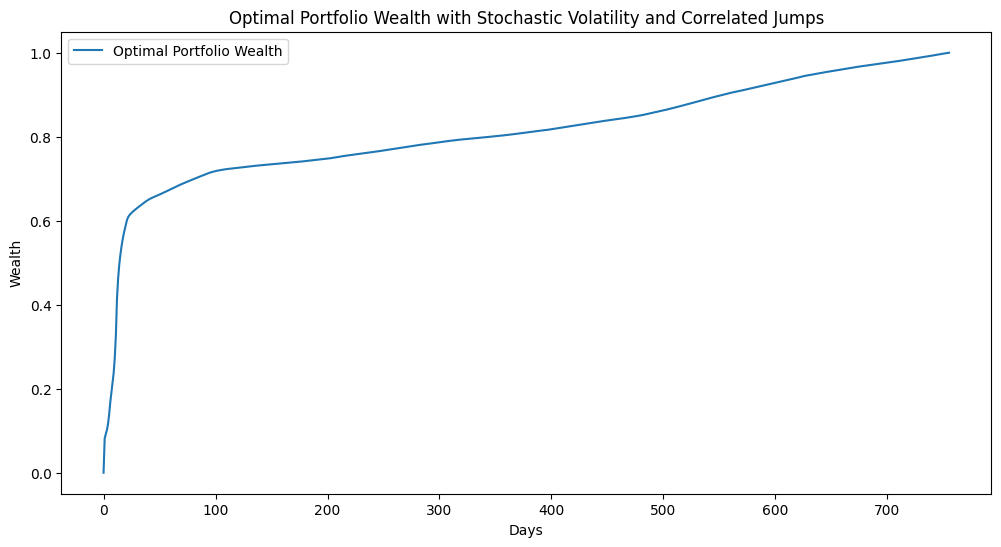

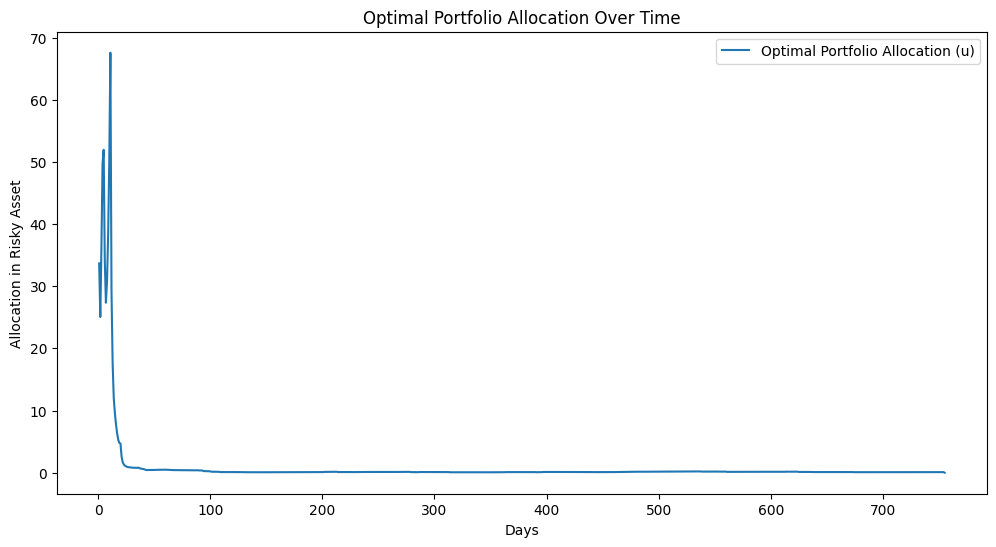

In [ ]:
# Implicit Finite Difference Solver for HJB Equation
def hjb_implicit_solver(market_data, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    # Initialize wealth
    V[-1] = 1.0  # Assume final wealth target is $1

    # Backward propagation using implicit finite difference
    for t in range(num_steps - 2, -1, -1):
        # Risk-free rate and stock prices
        # Change: Select a single stock price instead of the entire row
        stock_price = market_data.iloc[t, 0]  # Assuming the first column is the stock price
        r_t = 0.01  # Risk-free rate (constant for simplicity)

        # Portfolio allocation (u) - Solve for optimal u using dynamic programming
        sigma_t = np.std(market_data.iloc[:t+1, 0])  # Calculate std for the selected stock
        u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))  # Removed .mean()

        # Wealth update (implicit backward step)
        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.1  # Volatility of volatility
    sigma_0 = 0.2  # Initial volatility
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.1  # Jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.02] * len(tickers))  # Jump covariance matrix

    # Simulate market data with stochastic volatility and jumps
    market_data = simulate_market_data_with_heston_and_jumps(
        stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov
    )

    # Apply HJB optimization using implicit finite difference method
    theta_risk = 0.5  # Risk aversion parameter
    V_opt, u_opt = hjb_implicit_solver(market_data, theta_risk, len(market_data))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(V_opt, label='Optimal Portfolio Wealth')
    plt.title('Optimal Portfolio Wealth with Stochastic Volatility and Correlated Jumps')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(u_opt, label='Optimal Portfolio Allocation (u)')
    plt.title('Optimal Portfolio Allocation Over Time')
    plt.xlabel('Days')
    plt.ylabel('Allocation in Risky Asset')
    plt.legend()
    plt.show()